# Plate Velocities and Velocity Domains


In GPlates, so-called 'velocity domain points' can be created that allow us to compute continuous velocity fields across the globes. Typically, these points don't actually move with the reconstruction - rather, the points where we compute velocities are fixed geographically, and we determine the velocity at each point based on which polygon (a topological plate polygon, or a continental outline) the points lie within at the time for which we want to compute the velocity. For a more general introduction with illustrations, see the 'Velocity Field' tutorial at the GPlates tutorials website.
https://sites.google.com/site/gplatestutorials/


This notebook goes through examples of working with velocity domain points in pygplates, including
- generating velocity domain points at user-defined locations
- generate plate velocities within topological plate polygons, in two ways
  - as magnitude/azimuth
  - as north/east vector components
- do some basic plotting


#### Part 1: Creating Velocity Domain Points

The following cell contains a function that creates a GPlates gpml multipoint feature that contains points with the type 'Meshnode'. This is the same feature type created by the GPlates GUI dialog to create velocity domain points. For this function, the Long/Lat locations of each point are taken as input arrays to the function - they could be any set of points that you can define, for even just one point. This feature can be written to a file (then used in the GPlates GUI). 

Here, the function returns the meshnode feature for use in the later parts of the notebook.


In [2]:
import pygplates
import numpy as np

def make_GPML_velocity_feature(Long,Lat):
# function to make a velocity mesh nodes at an arbitrary set of points defined in Lat
# Long and Lat are assumed to be 1d arrays. 

    # Add points to a multipoint geometry
    SeedPoints = zip(Lat,Long)
    points = []
    for j in range(0,len(SeedPoints)):
        points.append(SeedPoints[j])
    multi_point = pygplates.MultiPointOnSphere(points)

    # Create a feature containing the multipoint feature, and defined as MeshNode type
    meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
    meshnode_feature.set_geometry(multi_point)
    meshnode_feature.set_name('Velocity Mesh Nodes from pygplates')

    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    # NB: at this point, the feature could be written to a file using
    # output_feature_collection.write('myfilename.gpmlz')
    
    # for use within the notebook, the velocity domain feature is returned from the function
    return output_feature_collection

    

For the example below, we create a regular geographic grid of points at a spacing of 5 degree in longitude and latitude. Then call the function to create a gpml meshnode feature with points at these locations

In [3]:
#######
# Run test case
# Generate points for regular long,lat grid
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)
Xg,Yg = np.meshgrid(Xnodes,Ynodes)
Xg = Xg.flatten()
Yg = Yg.flatten()

velocity_domain_features = make_GPML_velocity_feature(Xg,Yg)

The following code generates velocity values at each domain point, using resolved topological polygons to determine which plate each domain point is found within, and a rotation file to determine the motion of each plate. 

The steps involved are:
- create a 'plate_partitioner' based on the resolved topological polygons for the selected time
- iterate through each point in each feature of the domain points feature collection
- for each point 
 - find the plate id of the containing plate polygon 
 - find the stage rotation that describes the motion of this plate, using the reconstruction time and a 'delta time' (e.g. the velocity over the stage between 1 Ma and 0 Ma)
 - find the velocity at the point using this stage rotation  
 - convert the velocity vector to a representation including magnitude and azimuth
- repeat for all points, appending each result to a single list

In [4]:
import pygplates

rotation_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_2012.1.rot'

input_topology_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'

# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

# Load the topological plate polygon features.
topology_features = pygplates.FeatureCollection(input_topology_filename)

# Set the reconstruction time we want to compute the velocities
time = 0.

# Calculate velocities using a delta time interval of 1My.
delta_time = 1.

# All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
all_domain_points = []
all_velocities = []

# Partition our velocity domain features into our topological plate polygons at the current 'time'.
plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

for velocity_domain_feature in velocity_domain_features:

    # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
    # Iterate over them all.
    for velocity_domain_geometry in velocity_domain_feature.get_geometries():

        for velocity_domain_point in velocity_domain_geometry.get_points():

            all_domain_points.append(velocity_domain_point)

            partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
            if partitioning_plate:

                # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                # Calculate velocity at the velocity domain point.
                # This is from 'time + delta_time' to 'time' on the partitioning plate.
                velocity_vectors = pygplates.calculate_velocities(
                    [velocity_domain_point],
                    equivalent_stage_rotation,
                    delta_time)

                # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                velocities = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                        [velocity_domain_point],
                        velocity_vectors)
                all_velocities.append(velocities[0])

            else:
                all_velocities.append((0,0,0))
    

The result of this process is a list of velocity (magnitude,azimuth,inclination) tuples. Note that the inclination is always zero (or in some cases, a very small number close to zero). 

For plotting, we put these values into separate lists, and also put the Long,Lat coordinates into new lists as well (not strictly necessary here, but would be needed if we'd loaded the domain points from a file).


In [5]:
pt_vel_mag=[]
pt_vel_az=[]
for velocity_vector in all_velocities:
    pt_vel_mag.append(velocity_vector[0])
    pt_vel_az.append(velocity_vector[1])

pt_lon = []
pt_lat = []
for pt in all_domain_points:
    pt_lon.append(pt.to_lat_lon()[1])
    pt_lat.append(pt.to_lat_lon()[0])
    

The plot below is a simple scatter plot showing the velocity magnitude at each point mapped to colour. The velocity magnitudes generated on a regular grid could also be plotted using image/pcolor as a continuous grid. The plotted values show the significantly larger velocities in the Pacific domain compared to the 

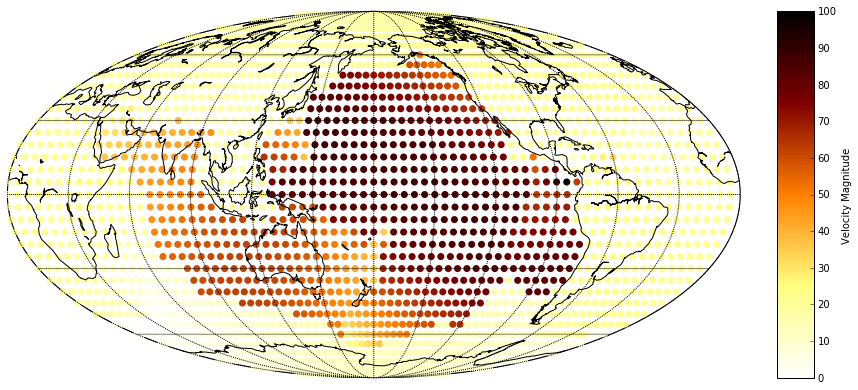

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid

%matplotlib inline

fig = plt.figure(figsize=(14,10),dpi=150)
ax_map = fig.add_axes([0,0,0.8,1.0])

m = Basemap(projection='moll', lon_0=180, resolution='c', ax=ax_map)
cp = m.drawmapboundary()
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))

x,y = m(pt_lon,pt_lat)
im = m.scatter(x,y,c=pt_vel_mag,edgecolor='',s=50,cmap=plt.cm.afmhot_r,vmin=0,vmax=100)

# add colorbar.
cbar = m.colorbar(im,location='right',pad="5%")
cbar.set_label('Velocity Magnitude')

plt.show()

### Plotting velocity vectors using basemap

To plot velocity vector arrows using basemap, we need the north and east components of the velocity vector.

The code below shows how to access these values - it is largely the same as the code above, the important difference occurs after the velocity vectors have been computed, after which the vectors are converted to the 'north_east_down' representation rather than 'magnitude_azimuth_inclination'.


In [7]:

# For variety, calculate velocities using a delta time interval of 5My.
delta_time = 5.

time = 0.

# All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
all_domain_points = []
all_velocities = []

# Partition our velocity domain features into our topological plate polygons at the current 'time'.
plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

for velocity_domain_feature in velocity_domain_features:

    # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
    # Iterate over them all.
    for velocity_domain_geometry in velocity_domain_feature.get_geometries():

        for velocity_domain_point in velocity_domain_geometry.get_points():

            all_domain_points.append(velocity_domain_point)

            partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
            if partitioning_plate:

                # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                # Calculate velocity at the velocity domain point.
                # This is from 'time + delta_time' to 'time' on the partitioning plate.
                velocity_vectors = pygplates.calculate_velocities(
                    [velocity_domain_point],
                    equivalent_stage_rotation,
                    delta_time)

                # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                velocities = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
                        [velocity_domain_point],
                        velocity_vectors)
                all_velocities.append(velocities[0])

            else:
                all_velocities.append((0,0,0))


Here we plot velocity vectors using a basemap and the quiver function (the vectors must be rotated into the coordinate system of the map - see the 'wind vectors' example on this page http://matplotlib.org/basemap/users/examples.html)

Note also the (potentially confusing) notation that GPlates uses for converting x and y directions to Long/Lat. 

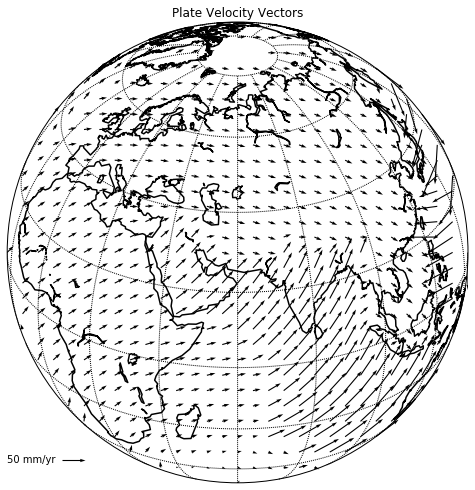

In [8]:
pt_vel_n=[]
pt_vel_e=[]
for vel in all_velocities:
    pt_vel_e.append(vel.get_y())
    pt_vel_n.append(vel.get_x())

u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0],Xnodes.shape[0]))
v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0],Xnodes.shape[0]))

m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=60.)
# create figure, add axes
fig1 = plt.figure(figsize=(8,10))
ax = fig1.add_axes([0.1,0.1,0.8,0.8])

lons, lats = np.meshgrid(Xnodes,Ynodes)
# compute native x,y coordinates of grid.
x, y = m(lons, lats)

uproj,vproj,xx,yy = \
m.transform_vector(u,v,Xnodes,Ynodes,31,31,returnxy=True,masked=True)
# now plot.
Q = m.quiver(xx,yy,uproj,vproj,scale=1000)
# make quiver key.
qk = plt.quiverkey(Q, 0.12, 0.05, 50, '50 mm/yr', labelpos='W')

# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5)
m.drawparallels(np.arange(-80.,90,20.))
m.drawmeridians(np.arange(0.,360.,20.))
# set plot title
ax.set_title('Plate Velocity Vectors')
plt.show()

The code in the above examples can be wrapped in a function that we can then call for arbitrary times. We will then call this function in subsequent examples, rather than repeating the same code over and over.

The last input variable 'rep' denotes the desired output represenation for the velocities, which as we have seen already can be either magnitude/azimuth or east/north components. 

In [9]:
def Get_Plate_Velocities(velocity_domain_features,topology_features,rotation_model,time,delta_time,rep):
    # Define a function 

    # All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
    all_domain_points = []
    all_velocities = []

    # Partition our velocity domain features into our topological plate polygons at the current 'time'.
    plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

    for velocity_domain_feature in velocity_domain_features:

        # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
        # Iterate over them all.
        for velocity_domain_geometry in velocity_domain_feature.get_geometries():

            for velocity_domain_point in velocity_domain_geometry.get_points():

                all_domain_points.append(velocity_domain_point)

                partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
                if partitioning_plate:

                    # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                    partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                    # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                    equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                    # Calculate velocity at the velocity domain point.
                    # This is from 'time + delta_time' to 'time' on the partitioning plate.
                    velocity_vectors = pygplates.calculate_velocities(
                        [velocity_domain_point],
                        equivalent_stage_rotation,
                        delta_time)
                    
                    if rep=='mag_azim':
                        # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                        velocities = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                            [velocity_domain_point],
                            velocity_vectors)
                        all_velocities.append(velocities[0])

                    elif rep=='vector_comp':
                        # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                        velocities = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
                                [velocity_domain_point],
                                velocity_vectors)
                        all_velocities.append(velocities[0])

                else:
                    all_velocities.append((0,0,0))

    return all_velocities


Now, we call the function using the same feature collections we already loaded/created, but for a different reconstruction time (and delta time, computing velocities averaged over the 60 to 50 Ma stage). 

The code that follows also plots the resolved topologies, with red lines defining ridge-transform boundaries, black lines delineating subduction zones and blue lines denoting all other boundary types. 

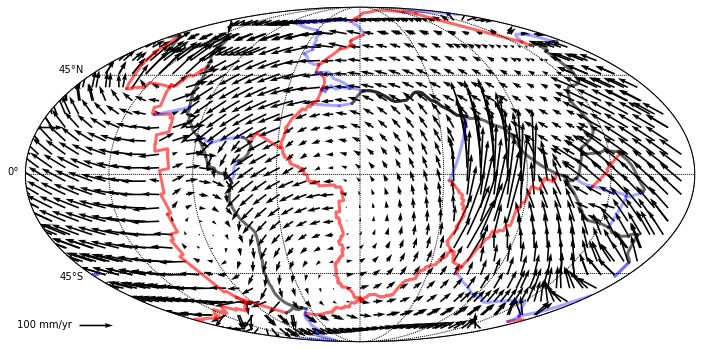

In [10]:
time = 50.
delta_time = 10.

# Call the function we created above to get the velocities
all_velocities = Get_Plate_Velocities(velocity_domain_features,
                                      topology_features,
                                      rotation_model,
                                      time,
                                      delta_time,
                                      'vector_comp')


# The rest of the cell is for plotting, including rendering resolved topological boundaries to the map
pt_vel_n=[]
pt_vel_e=[]
for vel in all_velocities:
    pt_vel_e.append(vel.get_y())
    pt_vel_n.append(vel.get_x())

u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0],Xnodes.shape[0]))
v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0],Xnodes.shape[0]))

# Create the basemap
fig = plt.figure(figsize=(12,8),dpi=300)
pmap = Basemap(resolution='c',projection='moll',lon_0=0.)
clip_path = pmap.drawmapboundary()
#pmap.drawmapboundary(fill_color='lightblue')
pmap.drawmeridians(np.arange(0, 360, 45))
pmap.drawparallels(np.arange(-90, 90, 45), labels=[1,0,0,0],fontsize=10)
ax = plt.gca()

# Resolve our topological plate polygons (and deforming networks) to the current 'time'.
# We generate both the resolved topology boundaries and the boundary sections between them.
resolved_topologies = []
shared_boundary_sections = []
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

# create a dateline wrapper object
wrapper = pygplates.DateLineWrapper(0.)

# Iterate over the shared boundary sections.
for shared_boundary_section in shared_boundary_sections:

    # The shared sub-segments contribute either to the ridges or to the subduction zones.
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('MidOceanRidge'):
        # Ignore zero length segments - they don't have a direction.
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X=[]
                Y=[]
                for point in geometry.get_points():
                    X.append(point.get_longitude()),Y.append(point.get_latitude())
                x,y = pmap(X,Y)
                pmap.plot(x,y,'r',clip_path=clip_path,linewidth=3,alpha=0.6, zorder=1)     

    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('SubductionZone'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X=[]
                Y=[]
                for point in geometry.get_points():
                    X.append(point.get_longitude()),Y.append(point.get_latitude())
                x,y = pmap(X,Y)
            pmap.plot(x,y,'k',clip_path=clip_path,linewidth=3,alpha=0.6, zorder=1)  

    else: #shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('FractureZone'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X=[]
                Y=[]
                for point in geometry.get_points():
                    X.append(point.get_longitude()),Y.append(point.get_latitude())
                x,y = pmap(X,Y)
            pmap.plot(x,y,'b',clip_path=clip_path,linewidth=3,alpha=0.35, zorder=1)  

lons, lats = np.meshgrid(Xnodes,Ynodes)
# compute native x,y coordinates of grid.
x, y = pmap(lons, lats)
# define parallels and meridians to draw.
parallels = np.arange(-80.,90,20.)
meridians = np.arange(0.,360.,20.)

uproj,vproj,xx,yy = \
pmap.transform_vector(u,v,Xnodes,Ynodes,51,26,returnxy=True,masked=True)
# now plot.
Q = pmap.quiver(xx,yy,uproj,vproj,scale=2000,clip_path=clip_path)
Q2 = pmap.quiver(xx,yy,uproj,vproj,scale=2000,color='')
# make quiver key.
qk = plt.quiverkey(Q2, 0.08, 0.05, 100, '100 mm/yr', labelpos='W',color='k')

plt.show()
    

Global RMS Velocity
NOTE - NEED TO USE A VELOCITY DOMAIN FILE THAT HAS EVENLY SPACED POINTS ON SPHERE
AND - THE CITCOM MESHES ARE SLIGHTLY PROBLEMATIC BECAUSE OF DUPLICATE POINTS 

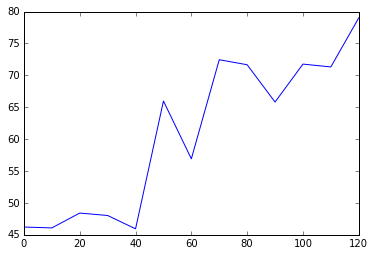

In [13]:
# Our geological times will be from 0Ma to 'num_time_steps' Ma (inclusive) in 1 My intervals.
max_time = 120
delta_time = 10.

RMS_velocity_list = []

velocity_domain_features = pygplates.FeatureCollection('test-notebooks/test65.gpmlz')

# 'time' = 0, 1, 2, ... , maxtime
for time in np.arange(0, max_time+1., delta_time):
    
    print 'Computing Velocities for Time = 'time
    # Get the global velocity field for this time 
    all_velocities = Get_Plate_Velocities(velocity_domain_features,
                                      topology_features,
                                      rotation_model,
                                      time,
                                      delta_time,
                                      'mag_azim')
    
    velocity_magnitude=[]
    for velocity_vector in all_velocities:
        velocity_magnitude.append(velocity_vector[0])
    
    RMS_velocity_for_stage = np.sqrt(np.mean(np.square(np.asarray(velocity_magnitude))))
    RMS_velocity_list.append(RMS_velocity_for_stage)
    
plt.plot(np.arange(0, max_time+1., delta_time),RMS_velocity_list)
plt.show()


For fun - plot velocities as a streamplot

'Warning: Cannot label meridians on full-disk
                Geostationary, Orthographic or Azimuthal equidistant basemap

/Users/Simon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in sqrt


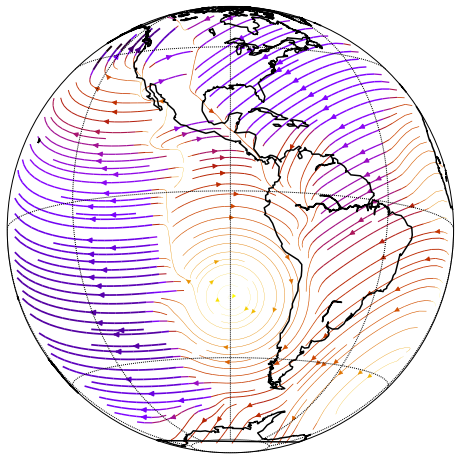

In [18]:
# Create the basemap
fig = plt.figure(figsize=(12,8),dpi=300)
pmap = Basemap(resolution='c',projection='ortho',lat_0=-10.,lon_0=-90.)
clip_path = pmap.drawmapboundary()
pmap.drawcoastlines(linewidth=1.5)

pmap.drawmeridians(np.arange(0, 360, 45), labels=[0,0,0,1],fontsize=10)
pmap.drawparallels(np.arange(-90, 90, 45), labels=[1,0,0,0],fontsize=10)
ax = plt.gca()

lons, lats = np.meshgrid(Xnodes,Ynodes)
# compute native x,y coordinates of grid.
x, y = pmap(lons, lats)
# define parallels and meridians to draw.
parallels = np.arange(-80.,90,20.)
meridians = np.arange(0.,360.,20.)
# transform vectors to projection grid.
uproj,vproj,xx,yy = \
pmap.transform_vector(u,v,Xnodes,Ynodes,101,51,returnxy=True,masked=True)
# now plot.

xxx, yyy = pmap.makegrid(uproj.shape[1], uproj.shape[0], returnxy=True)[2:4]

speed = np.sqrt(uproj**2 + vproj**2)
S = pmap.streamplot(xxx,yyy,uproj,vproj,color=speed, linewidth=0.02*speed, cmap=plt.cm.gnuplot_r, density=2)
S.arrows.set_clip_path(clip_path)
S.lines.set_clip_path(clip_path)

plt.show()
    